# Deep learning MNIST

Experiments using deep learning on the MNIST data set.

In [74]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = 'png'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import pickle, gzip, numpy

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
#train_set, valid_set, test_set = pickle.load(f)
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [4]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(data):
    X, y = data
    Y = OneHotEncoder().fit_transform(y.reshape(-1,1)).todense()
    X, Y, y = (_.astype(np.float32) for _ in (X, Y, y))
    return X, Y, y

In [5]:
Xtrain, Ytrain, ytrain = preprocess(train_set)
Xtest, Ytest, ytest = preprocess(test_set)

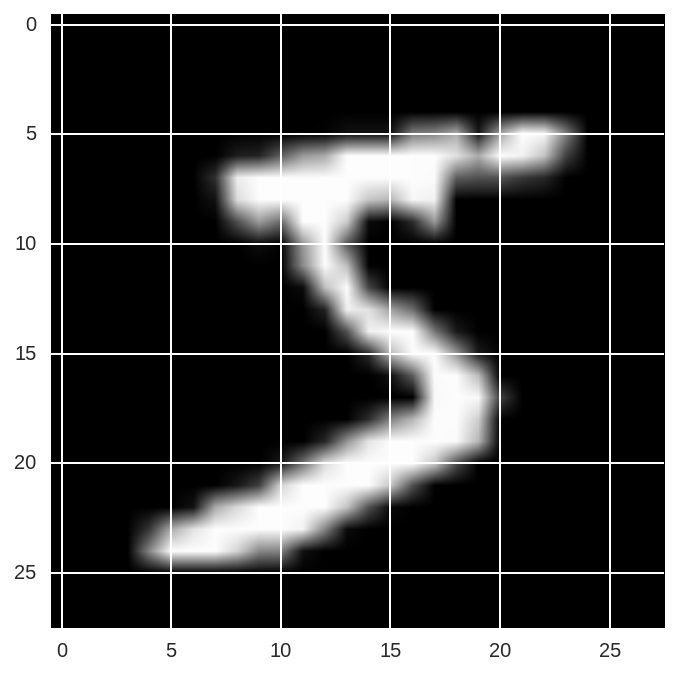

In [6]:
plt.imshow(Xtrain[0].reshape((28,28)), cmap=plt.cm.gray);

In [7]:
Ytrain[0]

matrix([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

# Logistic regression

Probability distribution over $k$ classes modeled as
$p = \sigma (W^T x)$,
where $x$ is a $d$-dimensional feature vector, $W$ is a $d \times k$ matrix, and $\sigma$ is the softmax function.

In [8]:
import theano.tensor as T
from theano import config, function, shared
from theano.tensor.nnet import softmax
from numpy.random import uniform, rand

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled)


In [9]:
d = 784
k = 10

In [10]:
def sgd(cost, params, lr=1):
    """Stochastic gradient descent update"""
    grads = T.grad(cost, wrt=params)
    return [(p, p - lr*gp) for p, gp in zip(params, grads)]

In [11]:
X = T.matrix('X')
Y = T.matrix('Y')

# randomly initialize weights and biases
W = shared(uniform(-1, 1, size=(d, k)).astype(config.floatX), 'W')
b = shared(uniform(-1, 1, size=(k,  )).astype(config.floatX), 'b')

P = softmax(T.dot(X, W) + b)
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W, b]))
predict = function([X], pred)
predict_proba = function([X], P)

In [12]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytest == predict(Xtest)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=9.7054 accuracy=0.0700
epoch=10 cost=1.8023 accuracy=0.5755
epoch=20 cost=1.1424 accuracy=0.7013
epoch=30 cost=0.9200 accuracy=0.7552
epoch=40 cost=0.8037 accuracy=0.7884
epoch=50 cost=0.7307 accuracy=0.8080
epoch=60 cost=0.6795 accuracy=0.8211
epoch=70 cost=0.6411 accuracy=0.8316
epoch=80 cost=0.6109 accuracy=0.8383
epoch=90 cost=0.5863 accuracy=0.8439
epoch=100 cost=0.5658 accuracy=0.8502
CPU times: user 9.29 s, sys: 1.15 s, total: 10.4 s
Wall time: 10.5 s


# Single hidden layer

In [13]:
from theano.tensor.nnet import relu

In [14]:
k0 = d  # input units
k1 = 25 # units in hidden layer
k2 = k  # output units

In [15]:
num_params = k0*k1 + k1*k2 + k1 + k2
num_params

19885

In [16]:
def init_weights(size):
    """Initialize random weights with scale recommended by Bengio et al."""
    b = np.sqrt(6/sum(size[:2]))
    return uniform(low=-b, high=b, size=size).astype(config.floatX)

In [17]:
X = T.matrix('X')
Y = T.matrix('Y')

W0 = shared(init_weights((k0,k1)), 'W0')
W1 = shared(init_weights((k1,k2)), 'W1')

b0 = shared(np.zeros(k1), 'b0')
b1 = shared(np.zeros(k2), 'b1')

A0 = X
A1 = relu(T.dot(A0, W0) + b0) # rectifier activation function
A2 = softmax(T.dot(A1, W1) + b1)

P = A2
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W0, b0, W1, b1], lr=0.3))
predict = function([X], pred)
predict_proba = function([X], P)

In [18]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytest == predict(Xtest)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=2.4003 accuracy=0.2087
epoch=10 cost=1.0634 accuracy=0.7176
epoch=20 cost=0.7031 accuracy=0.8143
epoch=30 cost=0.6335 accuracy=0.8252
epoch=40 cost=0.4994 accuracy=0.8758
epoch=50 cost=0.4446 accuracy=0.8889
epoch=60 cost=0.4156 accuracy=0.8931
epoch=70 cost=0.3951 accuracy=0.8960
epoch=80 cost=0.3783 accuracy=0.9003
epoch=90 cost=0.3641 accuracy=0.9034
epoch=100 cost=0.3526 accuracy=0.9065
CPU times: user 15.8 s, sys: 17.5 s, total: 33.3 s
Wall time: 12 s


# RMSprop

Idea: Scale the gradient by a moving average of the magnitude of gradients in previous updates. Speeds up convergence when exploring flatter regions, increases stability in steep regions. 

In [19]:
def rmsprop_(cost, params, lr=1, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = shared(p.get_value() * 0.) # trick to get 0 of correct type
        acc_new = rho*acc + (1-rho)*g**2
        scale = T.sqrt(acc_new + epsilon)
        g /= scale
        updates.append((acc, acc_new))
        updates.append((p, p - lr*g))
    return updates

In [20]:
updates = rmsprop_(cost, [W0, b0, W1, b1], lr=0.003)
train = function([X, Y], cost, updates=updates)

In [21]:
# reinitialize weights
W0.set_value(init_weights((k0, k1)))
W1.set_value(init_weights((k1, k2)))
b0.set_value(np.zeros(k1, dtype=config.floatX))
b1.set_value(np.zeros(k2, dtype=config.floatX))

In [22]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain)
    if i % 10 == 0:
        accuracy = (ytest == predict(Xtest)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=2.4472 accuracy=0.3311
epoch=10 cost=1.0666 accuracy=0.7466
epoch=20 cost=0.7138 accuracy=0.8551
epoch=30 cost=0.5589 accuracy=0.8729
epoch=40 cost=0.4682 accuracy=0.8870
epoch=50 cost=0.4216 accuracy=0.8935
epoch=60 cost=0.3781 accuracy=0.8994
epoch=70 cost=0.3443 accuracy=0.9087
epoch=80 cost=0.3285 accuracy=0.9106
epoch=90 cost=0.3130 accuracy=0.9138
epoch=100 cost=0.2971 accuracy=0.9180
CPU times: user 16.2 s, sys: 17.6 s, total: 33.8 s
Wall time: 12.1 s


In [23]:
(ytest == predict(Xtest)).mean()

0.91800000000000004

In [24]:
(ytrain == predict(Xtrain)).mean()

0.91764000000000001

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

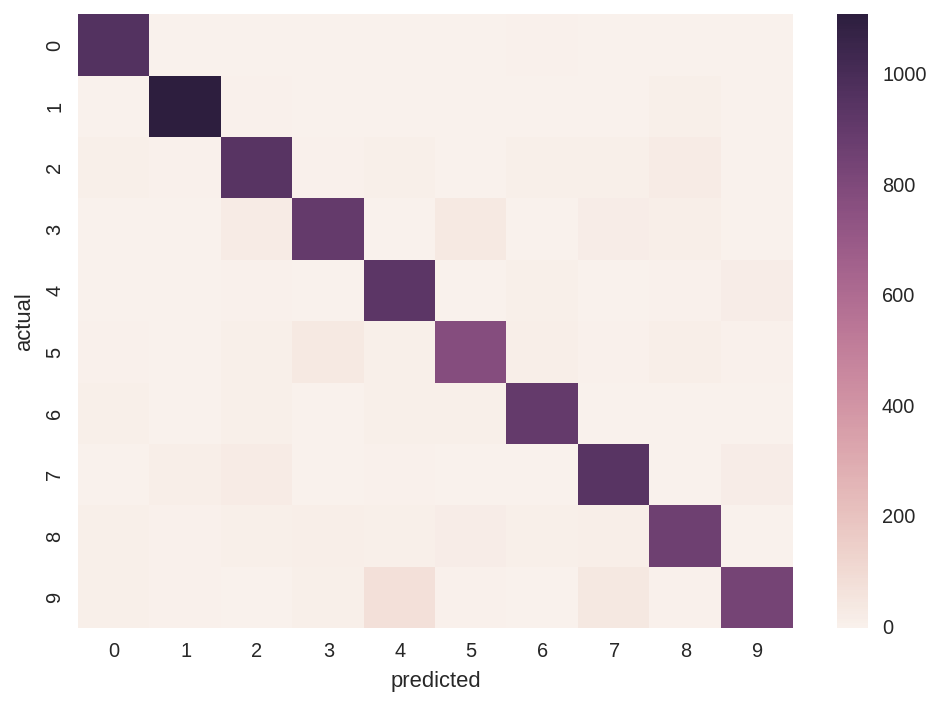

In [26]:
sns.heatmap(confusion_matrix(ytest, predict(Xtest)))
plt.xlabel('predicted')
plt.ylabel('actual');

# CNN (LeNet)

In [27]:
import theano
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

In [28]:
w0 = 28 # image size

In [29]:
Xtrain2d = Xtrain.reshape(-1, 1, 28, 28)
Xtest2d = Xtest.reshape(-1, 1, 28, 28)

In [30]:
Xtrain2d.shape

(50000, 1, 28, 28)

In [31]:
l = 3 # kernel size
p = 2 # pool size

w1 = int((w0 - l + 1)/2) # size of image in layer 1
w2 = int((w1 - l + 1)/2) # etc.
w2

5

In [32]:
k0 = 1 # number of input channels (e.g. grayscale -> 1)
k1 = 4 # number of kernels in the first layer
k2 = 6 # etc...
k3 = k # number of output units

In [33]:
def init_weights_as(size):
    """Initialize random weights with scale recommended by Bengio et al."""
    b = np.sqrt(6/sum(size[:2]))
    return uniform(low=-b, high=b, size=size).astype(config.floatX)

In [34]:
X = T.tensor4('X')
Y = T.matrix('Y')

# weights for convolutional layers: 4-tensor per layer with
# shape = (num_kernels = num_output_feature_maps, 
#          num_input_feature_maps,
#          kernel_width, 
#          kernel_height)
w0 = shared(init_weights_as((k1, k0, l, l)), 'w0')
w1 = shared(init_weights_as((k2, k1, l, l)), 'w1')

# weights for fully-connected layer
# num_inputs = num_input_feature_maps * feature_map_size**2
#            = k2 * w2**2
W2 = shared(init_weights_as((k2*w2**2, k3)), 'W2')

# biases
b0 = shared(np.zeros(k1, dtype=config.floatX))
b1 = shared(np.zeros(k2, dtype=config.floatX))
b2 = shared(np.zeros(k3, dtype=config.floatX))

A0 = X

# 1st convolution and downsampling
# broadcast bias across all examples, image rows, image cols
A1 = relu(conv2d(A0, w0) + b0.dimshuffle('x',0,'x','x'))
a1 = max_pool_2d(A1, (p,p), ignore_border=True)

# 2nd convolution and downsampling
A2 = relu(conv2d(a1, w1) + b1.dimshuffle('x',0,'x','x'))
a2 = max_pool_2d(A2, (p,p), ignore_border=True)
           
# fully-connected output layer
A3  = softmax(T.dot(a2.flatten(2), W2) + b2)
P = A3

# standard stuff
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1)) # cross-entropy
params = [w0, b0, w1, b1, W2, b2]
updates = rmsprop_(cost, params, lr=0.003)
train = function([X, Y], cost, updates=updates)
predict = function([X], pred)
predict_proba = function([X], P)

In [35]:
num_params = sum(p.get_value().size for p in params)
num_params

1772

In [36]:
%%time
for i in range(101):
    c = train(Xtrain2d, Ytrain)
    if i % 10 == 0:
        accuracy = (ytest == predict(Xtest2d)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), accuracy))

epoch=0 cost=4.6045 accuracy=0.2078
epoch=10 cost=1.2965 accuracy=0.5824
epoch=20 cost=0.8752 accuracy=0.7286
epoch=30 cost=0.6470 accuracy=0.8002
epoch=40 cost=0.5212 accuracy=0.8441
epoch=50 cost=0.4407 accuracy=0.8701
epoch=60 cost=0.3865 accuracy=0.8859
epoch=70 cost=0.3534 accuracy=0.8999
epoch=80 cost=0.3119 accuracy=0.9141
epoch=90 cost=0.2979 accuracy=0.9131
epoch=100 cost=0.2573 accuracy=0.9255
CPU times: user 52.5 s, sys: 7.5 s, total: 1min
Wall time: 1min


# Using Lasagne

In [37]:
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer, MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import rectify, softmax
from lasagne.init import GlorotUniform
from lasagne.updates import rmsprop

In [38]:
X = T.tensor4('X')
y = T.ivector('y')

net = InputLayer(shape=(None, 1, 28, 28), input_var=X)

net = Conv2DLayer(
    net, 
    num_filters=4, 
    filter_size=(3,3),
    nonlinearity=rectify,
    W=GlorotUniform()
)

net = MaxPool2DLayer(net, pool_size=(2,2))

net = Conv2DLayer(
    net, 
    num_filters=6, 
    filter_size=(3,3),
    nonlinearity=rectify,
    W=GlorotUniform()
)

net = MaxPool2DLayer(net, pool_size=(2,2))

net = DenseLayer(
    net, # lasagne.layers.dropout(net, p=0.5),
    num_units=10,
    nonlinearity=softmax
)

output = lasagne.layers.get_output(net)
pred = T.argmax(output, axis=1)
loss = lasagne.objectives.categorical_crossentropy(output, y).mean()
params = lasagne.layers.get_all_params(net, trainable=True)
#updates = rmsprop(loss, params, learning_rate=0.003, rho=0.9, epsilon=1e-6)
updates = rmsprop_(loss, params, lr=0.003)
train = function([X, y], loss, updates=updates)
accuracy = function([X, y], T.mean(T.eq(pred, y)))

/usr/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/tensor/nnet/__init__.py:111: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  warnings.warn("The `image_shape` keyword argument to "


In [39]:
num_params = sum(p.get_value().size for p in params)
num_params

1772

In [40]:
Xtrain2d = Xtrain.reshape(-1, 1, 28, 28)
Xtest2d = Xtest.reshape(-1, 1, 28, 28)

In [41]:
ytrain_ = ytrain.astype(np.int32)
ytest_ = ytest.astype(np.int32)

In [42]:
%%time
for i in range(101):
    c = train(Xtrain2d, ytrain_)
    if i % 10 == 0:
        acc = accuracy(Xtest2d, ytest_)
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), acc.item()))

epoch=0 cost=2.3254 accuracy=0.1283
epoch=10 cost=1.8659 accuracy=0.6195
epoch=20 cost=1.1089 accuracy=0.7563
epoch=30 cost=0.7666 accuracy=0.8061
epoch=40 cost=0.6236 accuracy=0.8298
epoch=50 cost=0.5410 accuracy=0.8467
epoch=60 cost=0.4863 accuracy=0.8615
epoch=70 cost=0.4430 accuracy=0.8747
epoch=80 cost=0.4114 accuracy=0.8868
epoch=90 cost=0.3844 accuracy=0.8910
epoch=100 cost=0.3513 accuracy=0.9022
CPU times: user 47.3 s, sys: 6.63 s, total: 53.9 s
Wall time: 54 s


# Improved network

- add second dense layer before output
- dropout regularization with `p=0.5` for dense layers
- increase number of filters to 8 in the first convolution layer, 32 in second
- increase filter size in second convolution layer
- use ADAM optimization
- mini-batch training

In [43]:
from lasagne.layers import dropout
from lasagne.updates import adam

In [58]:
net = InputLayer(shape=(None, 1, 28, 28), input_var=X)


# Convolution/downsampling layers

net = Conv2DLayer(
    net, 
    num_filters=16, 
    filter_size=(5,5),
    nonlinearity=rectify,
    W=GlorotUniform()
)

net = MaxPool2DLayer(net, pool_size=(2,2))

net = Conv2DLayer(
    net, 
    num_filters=16, 
    filter_size=(5,5),
    nonlinearity=rectify,
    W=GlorotUniform()
)

net = MaxPool2DLayer(net, pool_size=(2,2))


# Multi-layer perceptron to output

net = DenseLayer(
    dropout(net, p=0.5),
    num_units=128,
    nonlinearity=rectify
)

net = DenseLayer(
    dropout(net, p=0.5),
    num_units=10,
    nonlinearity=softmax
)


# Standard stuff
output = lasagne.layers.get_output(net)
output_det = lasagne.layers.get_output(net, deterministic=True)
pred = T.argmax(output, axis=1)
pred_det = T.argmax(output_det, axis=1)
loss = lasagne.objectives.categorical_crossentropy(output, y).mean()
params = lasagne.layers.get_all_params(net, trainable=True)
updates = adam(loss, params)
train = function([X, y], loss, updates=updates)
accuracy = function([X, y], T.mean(T.eq(pred_det, y)))

/usr/lib/python3.5/site-packages/Theano-0.7.0-py3.5.egg/theano/tensor/nnet/__init__.py:111: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  warnings.warn("The `image_shape` keyword argument to "


In [59]:
num_params = sum(p.get_value().size for p in params)
num_params

41018

In [60]:
def iterate_batches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [61]:
%%time
for i in range(101):
    for batch in iterate_batches(Xtrain2d, ytrain_, 500, shuffle=True):
        X_batch, y_batch = batch
        c = train(X_batch, y_batch)
    if i % 10 == 0:
        acc = accuracy(Xtest2d, ytest_)
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c.item(), acc.item()))

epoch=0 cost=0.4763 accuracy=0.9402
epoch=10 cost=0.1219 accuracy=0.9863
epoch=20 cost=0.0676 accuracy=0.9904
epoch=30 cost=0.0827 accuracy=0.9920
epoch=40 cost=0.0285 accuracy=0.9929
epoch=50 cost=0.0606 accuracy=0.9922
epoch=60 cost=0.0484 accuracy=0.9932
epoch=70 cost=0.0449 accuracy=0.9931
epoch=80 cost=0.0710 accuracy=0.9937
epoch=90 cost=0.0583 accuracy=0.9929
epoch=100 cost=0.0537 accuracy=0.9937
CPU times: user 2min 5s, sys: 36 s, total: 2min 41s
Wall time: 2min 45s


In [80]:
params = lasagne.layers.get_all_param_values(net)
with open('cnn_params.pkl', 'wb') as f:
    pickle.dump(params, f)